In [1]:
import pandas as pd
# import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体（Windows系统）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 加载数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print("训练集形状:", train_data.shape)
print("测试集形状:", test_data.shape)
print("\n训练集基本信息:")
print(train_data.info())

训练集形状: (891, 12)
测试集形状: (418, 11)

训练集基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


训练集缺失值:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

测试集缺失值:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


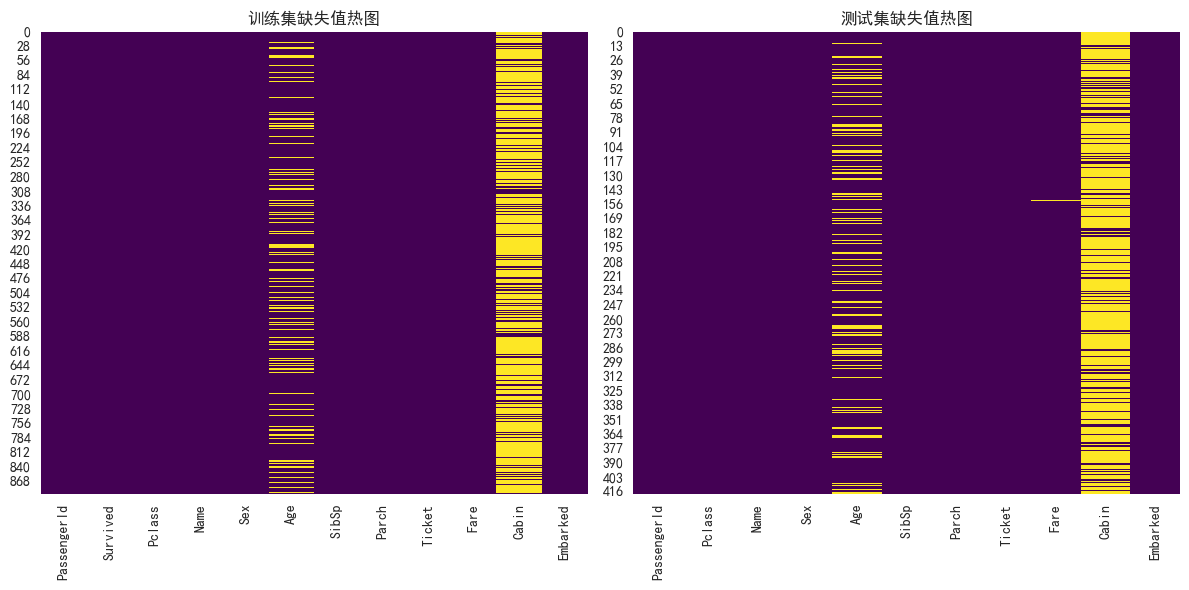

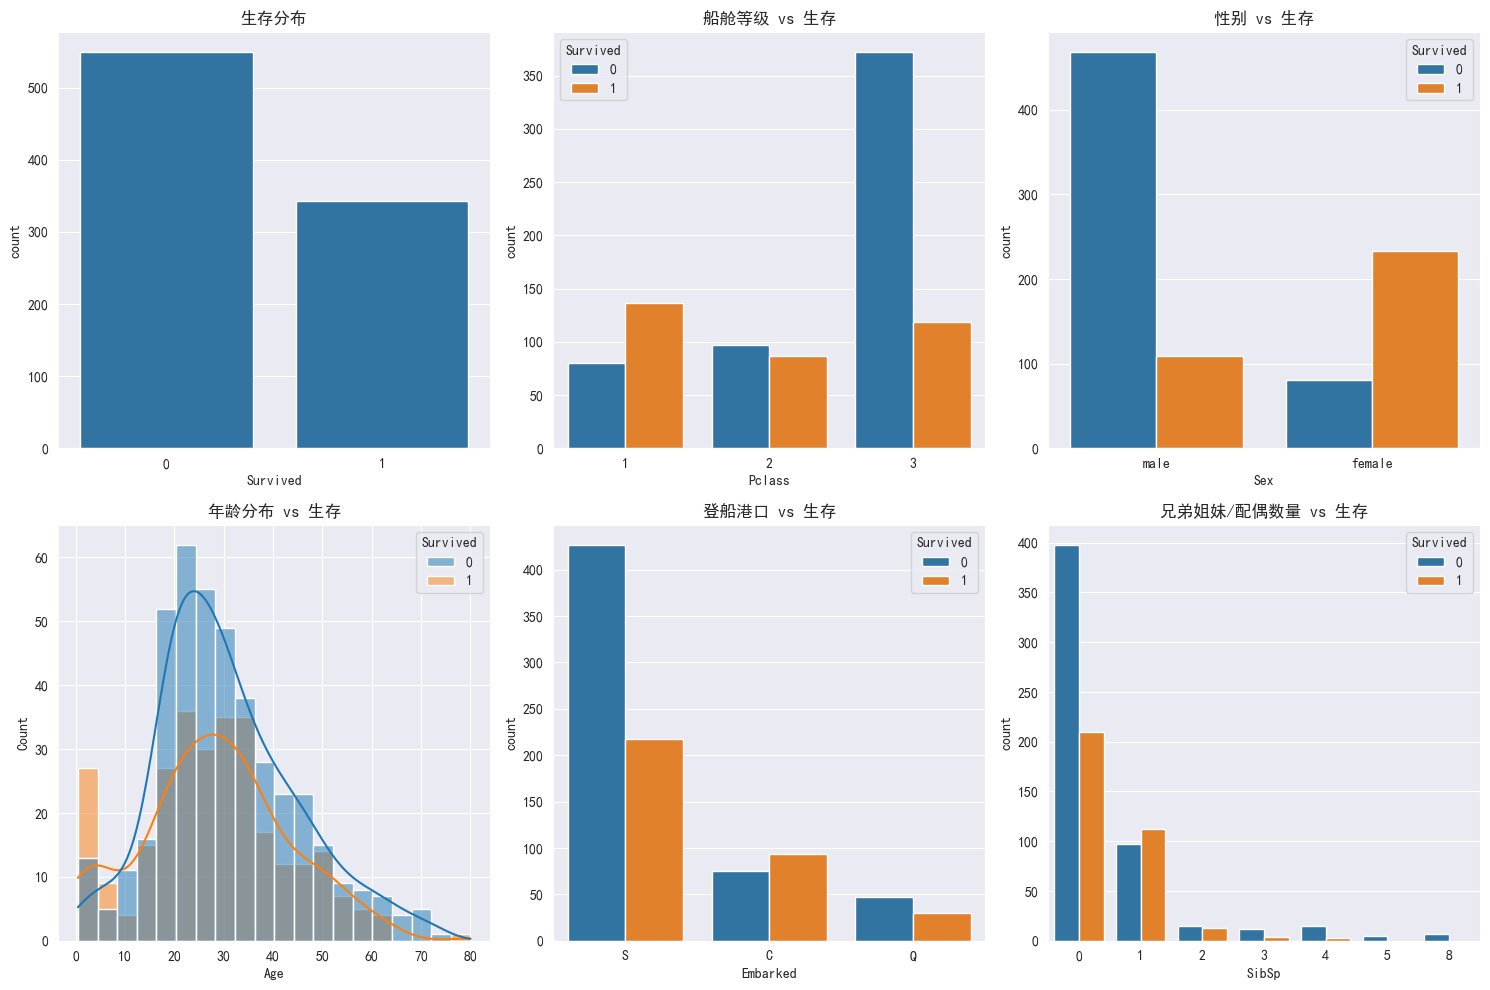

In [2]:
# 查看缺失值
print("训练集缺失值:")
print(train_data.isnull().sum())
print("\n测试集缺失值:")
print(test_data.isnull().sum())

# 可视化缺失值
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title('训练集缺失值热图')

plt.subplot(1, 2, 2)
sns.heatmap(test_data.isnull(), cbar=False, cmap='viridis')
plt.title('测试集缺失值热图')
plt.tight_layout()
plt.show()

# 生存率分析
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.countplot(x='Survived', data=train_data)
plt.title('生存分布')

plt.subplot(2, 3, 2)
sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.title('船舱等级 vs 生存')

plt.subplot(2, 3, 3)
sns.countplot(x='Sex', hue='Survived', data=train_data)
plt.title('性别 vs 生存')

plt.subplot(2, 3, 4)
sns.histplot(x='Age', hue='Survived', data=train_data, kde=True)
plt.title('年龄分布 vs 生存')

plt.subplot(2, 3, 5)
sns.countplot(x='Embarked', hue='Survived', data=train_data)
plt.title('登船港口 vs 生存')

plt.subplot(2, 3, 6)
sns.countplot(x='SibSp', hue='Survived', data=train_data)
plt.title('兄弟姐妹/配偶数量 vs 生存')

plt.tight_layout()
plt.show()

In [3]:
def preprocess_data(df):
    """
    数据预处理函数
    """
    df_processed = df.copy()
    
    # 1. 处理缺失值
    # Age: 用中位数填充
    df_processed['Age'].fillna(df_processed['Age'].median(), inplace=True)
    
    # Fare: 用中位数填充
    df_processed['Fare'].fillna(df_processed['Fare'].median(), inplace=True)
    
    # Embarked: 用众数填充
    df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0], inplace=True)
    
    # Cabin: 缺失数据过多，直接舍弃
    df_processed.drop(columns=['Cabin'], inplace=True)
    
    # 2. 特征工程
    # 家庭大小
    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1
    
    # 是否独自旅行
    df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)

    # 以下不采用
    """
    # 姓名长度（可能与社会地位相关）
    df_processed['NameLength'] = df_processed['Name'].apply(len)
    
    # 从姓名中提取头衔
    df_processed['Title'] = df_processed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_mapping = {
        'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 
        'Rev': 6, 'Col': 7, 'Major': 7, 'Mlle': 2, 'Countess': 3,
        'Ms': 2, 'Lady': 3, 'Jonkheer': 1, 'Don': 1, 'Dona': 3,
        'Mme': 3, 'Capt': 7, 'Sir': 1
    }
    df_processed['Title'] = df_processed['Title'].map(title_mapping)
    df_processed['Title'].fillna(0, inplace=True)  # 未知头衔
    """
    
    # 年龄分组
    df_processed['AgeGroup'] = pd.cut(df_processed['Age'], 
                                     bins=[0, 12, 18, 35, 60, 100], 
                                     labels=[1, 2, 3, 4, 5]).astype(int)
    
    # 票价分组
    df_processed['FareGroup'] = pd.qcut(df_processed['Fare'], 4, labels=[1, 2, 3, 4]).astype(int)
    
    # 3. 编码分类变量
    le = LabelEncoder()
    df_processed['Sex'] = le.fit_transform(df_processed['Sex'])  # 0=female, 1=male
    df_processed['Embarked'] = le.fit_transform(df_processed['Embarked'])
    
    # 4. 选择特征
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                'Embarked', 'FamilySize', 'IsAlone', 
                'AgeGroup', 'FareGroup']
    
    return df_processed[features]

# 应用预处理
X_train = preprocess_data(train_data)
y_train = train_data['Survived']
X_test = preprocess_data(test_data)

print("预处理后的特征形状:")
print(f"训练集: {X_train.shape}")
print(f"测试集: {X_test.shape}")

预处理后的特征形状:
训练集: (891, 11)
测试集: (418, 11)


In [4]:
# 标准化数值特征
scaler = StandardScaler()

# 需要标准化的数值特征列
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print("标准化后的数据样例:")
print(X_train_scaled.head())

标准化后的数据样例:
   Pclass  Sex       Age     SibSp     Parch      Fare  Embarked  FamilySize  \
0       3    1 -0.565736  0.432793 -0.473674 -0.502445         2    0.059160   
1       1    0  0.663861  0.432793 -0.473674  0.786845         0    0.059160   
2       3    0 -0.258337 -0.474545 -0.473674 -0.488854         2   -0.560975   
3       1    0  0.433312  0.432793 -0.473674  0.420730         2    0.059160   
4       3    1  0.433312 -0.474545 -0.473674 -0.486337         2   -0.560975   

   IsAlone  AgeGroup  FareGroup  
0        0         3          1  
1        0         4          4  
2        1         3          2  
3        0         3          4  
4        1         3          2  



训练 Decision Tree 模型
Decision Tree 交叉验证准确率: 0.7800 (+/- 0.0478)
详细交叉验证分数: [0.77653631 0.78651685 0.79775281 0.73595506 0.80337079]

训练 Naive Bayes 模型
Naive Bayes 交叉验证准确率: 0.7712 (+/- 0.0995)
详细交叉验证分数: [0.67597765 0.76966292 0.79775281 0.79775281 0.81460674]

训练 SVM 模型
SVM 交叉验证准确率: 0.8238 (+/- 0.0271)
详细交叉验证分数: [0.82122905 0.8258427  0.80898876 0.81460674 0.84831461]

训练 Random Forest 模型
Random Forest 交叉验证准确率: 0.8148 (+/- 0.0536)
详细交叉验证分数: [0.7877095  0.80898876 0.85393258 0.78651685 0.83707865]


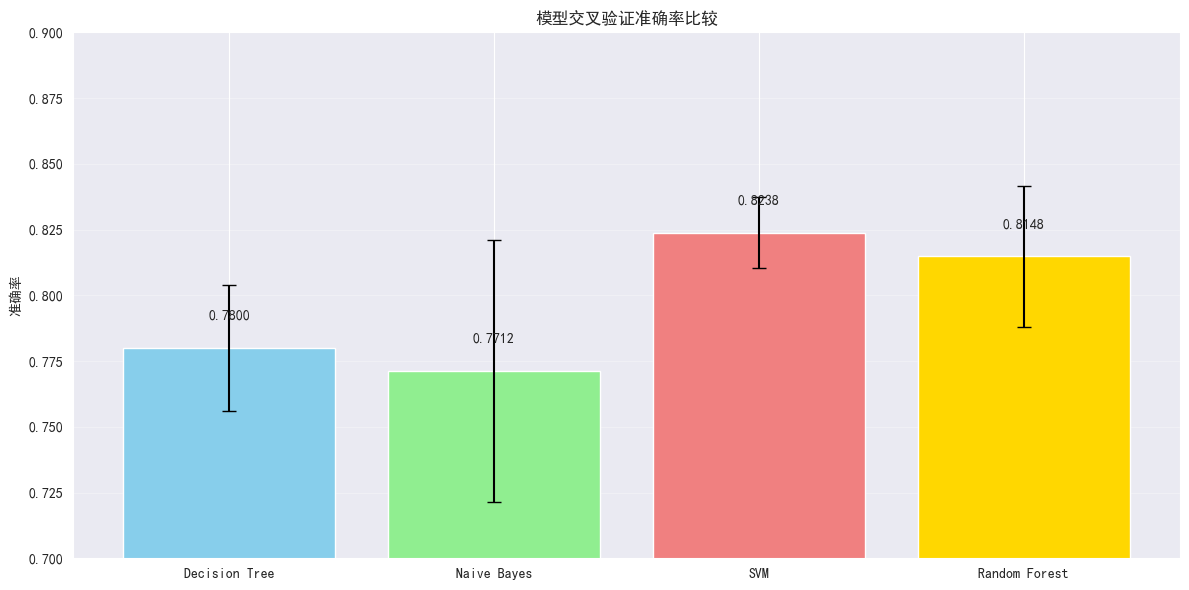

In [5]:
# 定义模型
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# 存储结果
results = {}
cv_results = {}

# 训练和评估每个模型
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"训练 {name} 模型")
    print('='*50)
    
    # 交叉验证
    if name == 'Naive Bayes':
        # 朴素贝叶斯使用未标准化的数据（高斯NB假设特征符合正态分布）
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    else:
        # 其他模型使用标准化后的数据
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    cv_results[name] = cv_scores
    
    # 训练模型
    if name == 'Naive Bayes':
        model.fit(X_train, y_train)
    else:
        model.fit(X_train_scaled, y_train)
    
    # 存储模型
    results[name] = model
    
    print(f"{name} 交叉验证准确率: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"详细交叉验证分数: {cv_scores}")

# 比较模型性能
plt.figure(figsize=(12, 6))
model_names = list(cv_results.keys())
model_scores = [scores.mean() for scores in cv_results.values()]
model_stds = [scores.std() for scores in cv_results.values()]

plt.bar(model_names, model_scores, yerr=model_stds, capsize=5, 
        color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('模型交叉验证准确率比较')
plt.ylabel('准确率')
plt.ylim(0.7, 0.9)
plt.grid(axis='y', alpha=0.3)

# 在柱状图上显示数值
for i, v in enumerate(model_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Decision Tree 模型在验证集上的表现:
准确率: 0.9944

分类报告:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       110
           1       1.00      0.99      0.99        69

    accuracy                           0.99       179
   macro avg       1.00      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



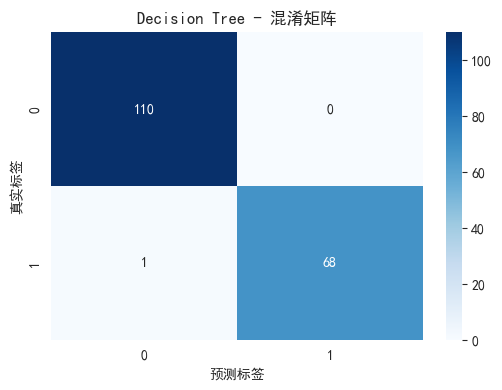


Naive Bayes 模型在验证集上的表现:
准确率: 0.7430

分类报告:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       110
           1       0.67      0.67      0.67        69

    accuracy                           0.74       179
   macro avg       0.73      0.73      0.73       179
weighted avg       0.74      0.74      0.74       179



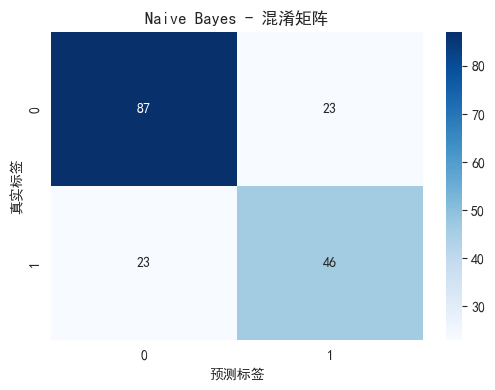


SVM 模型在验证集上的表现:
准确率: 0.8268

分类报告:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



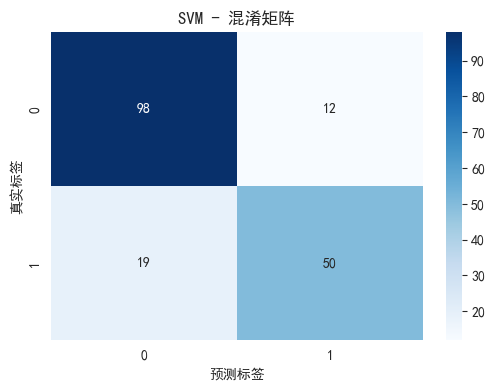


Random Forest 模型在验证集上的表现:
准确率: 0.9888

分类报告:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       110
           1       0.99      0.99      0.99        69

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



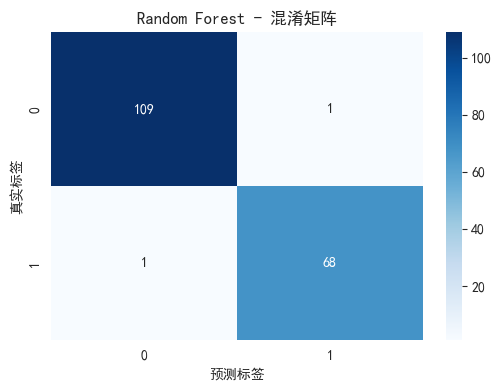

In [6]:
# 使用部分训练数据作为验证集进行详细评估
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 对每个模型进行详细评估
for name, model in results.items():
    if name == 'Naive Bayes':
        # 朴素贝叶斯使用未标准化的验证集
        X_val = X_train.iloc[X_val_split.index]
        y_pred = model.predict(X_val)
    else:
        X_val = X_val_split
        y_pred = model.predict(X_val_split)
    
    accuracy = accuracy_score(y_val_split, y_pred)
    
    print(f"\n{name} 模型在验证集上的表现:")
    print(f"准确率: {accuracy:.4f}")
    print("\n分类报告:")
    print(classification_report(y_val_split, y_pred))
    
    # 混淆矩阵
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_val_split, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - 混淆矩阵')
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.show()

In [7]:
# 在测试集上进行预测
test_predictions = {}

for name, model in results.items():
    if name == 'Naive Bayes':
        # 朴素贝叶斯使用未标准化的测试集
        test_pred = model.predict(X_test)
    else:
        test_pred = model.predict(X_test_scaled)
    
    test_predictions[name] = test_pred
    print(f"{name} 测试集预测完成，样本数: {len(test_pred)}")

# 创建提交文件
for name, pred in test_predictions.items():
    submission = pd.DataFrame({
        'PassengerId': test_data['PassengerId'],
        'Survived': pred
    })
    
    # 保存提交文件
    filename = f'titanic_submission_{name.replace(" ", "_").lower()}.csv'
    submission.to_csv(filename, index=False)
    print(f"{name} 的预测结果已保存到: {filename}")

# 比较不同模型的预测结果差异
comparison_df = pd.DataFrame(test_predictions)
comparison_df['PassengerId'] = test_data['PassengerId']

print("\n不同模型预测结果比较:")
print("前10个样本的预测结果:")
print(comparison_df.head(10))

# 统计预测一致的比例
agree_count = 0
total_samples = len(comparison_df)

for i in range(total_samples):
    predictions = comparison_df.iloc[i][list(models.keys())].values
    if len(set(predictions)) == 1:  # 所有模型预测一致
        agree_count += 1

print(f"\n模型预测一致的比例: {agree_count/total_samples:.4f} ({agree_count}/{total_samples})")

Decision Tree 测试集预测完成，样本数: 418
Naive Bayes 测试集预测完成，样本数: 418
SVM 测试集预测完成，样本数: 418
Random Forest 测试集预测完成，样本数: 418
Decision Tree 的预测结果已保存到: titanic_submission_decision_tree.csv
Naive Bayes 的预测结果已保存到: titanic_submission_naive_bayes.csv
SVM 的预测结果已保存到: titanic_submission_svm.csv
Random Forest 的预测结果已保存到: titanic_submission_random_forest.csv

不同模型预测结果比较:
前10个样本的预测结果:
   Decision Tree  Naive Bayes  SVM  Random Forest  PassengerId
0              0            0    0              0          892
1              0            1    1              0          893
2              1            0    0              0          894
3              1            0    0              1          895
4              1            1    1              0          896
5              0            0    0              0          897
6              0            0    1              0          898
7              0            0    0              0          899
8              1            1    1              1          900
9       